# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In [1]:
save_augmented_data = False

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

use_n_channels = 3

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

In [4]:
import csv

with open('signnames.csv', mode='rt') as file:
    file.readline()   # discard header
    sign_names = { int(r[0]) : r[1] for r in csv.reader(file) }

##### Original Data Preview

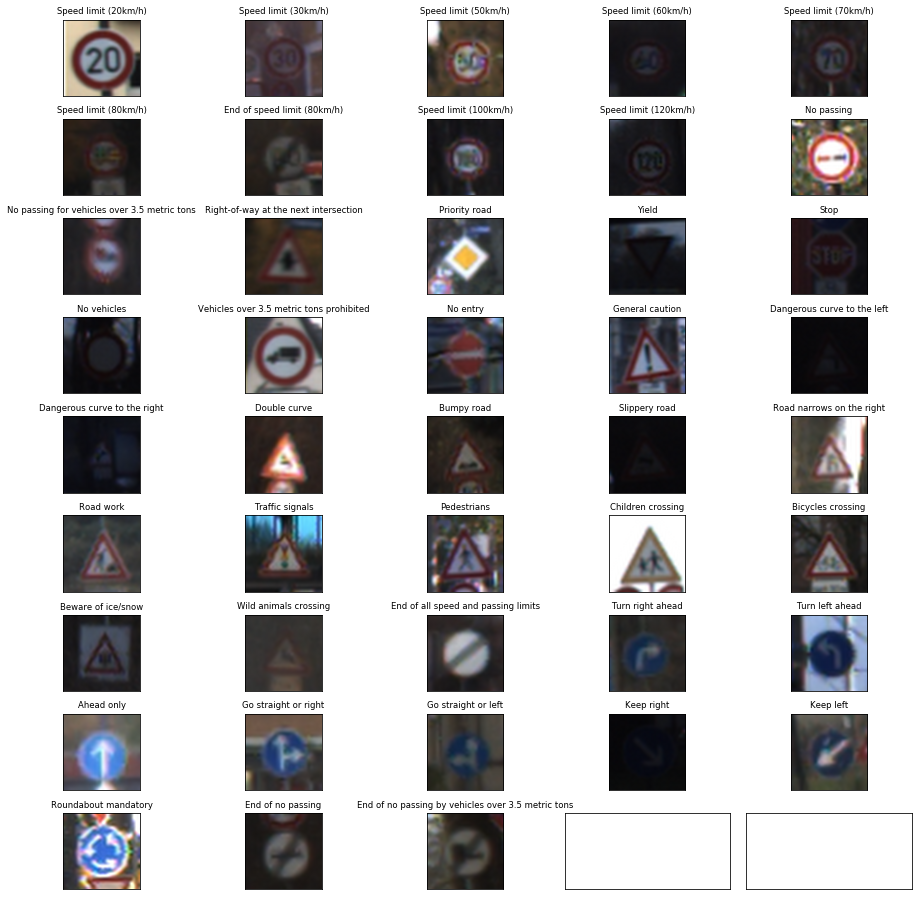

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline 

classes, indices = np.unique(y_train, return_index=True)   

columns = 5
rows = math.ceil(n_classes/columns)
figsize=(16, 16)
fontsize=8.5

fig, axes = plt.subplots(rows, columns, figsize=figsize,
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.10)

for ax, i in zip(axes.flat, indices):
    ax.imshow(X_train[i], interpolation='lanczos', cmap='viridis')
    ax.set_title(sign_names[y_train[i]], fontsize=fontsize)
    
plt.show()

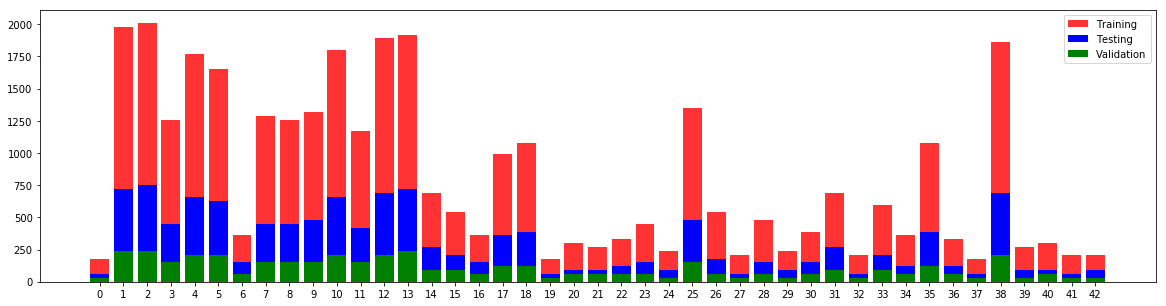

In [6]:
from collections import Counter

fig, ax = plt.subplots(figsize=(20,5))

D = Counter(y_train)
plt.xticks(range(len(D)), D.keys())
plt.bar(range(len(D)), D.values(), color="red", alpha=0.8, label='Training')

D = Counter(y_test)
plt.xticks(range(len(D)), D.keys())
plt.bar(range(len(D)), D.values(), color="blue",label='Testing')

D = Counter(y_valid)
plt.xticks(range(len(D)), D.keys())
plt.bar(range(len(D)), D.values(), color="green",label='Validation')

legend = ax.legend()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set 

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

In [7]:
from sklearn.utils import shuffle
import tensorflow as tf

def preprocess_gpu(x_in):
    x_t = tf.cast(x_in, dtype=tf.float32)
    x_out = []
    if use_n_channels == 1:
        x_t = tf.image.rgb_to_grayscale(x_t)  
    x_t = tf.map_fn(lambda img: tf.image.per_image_standardization(img), x_t, dtype=tf.float32)
    
    with tf.Session() as sess:
        x_out = x_t.eval()
    return x_out


In [8]:
%%time
X_train = preprocess_gpu(X_train)
X_valid = preprocess_gpu(X_valid)
X_test = preprocess_gpu(X_test)

CPU times: user 30.1 s, sys: 7.84 s, total: 38 s
Wall time: 17.1 s


##### Prepocessed Data Preview

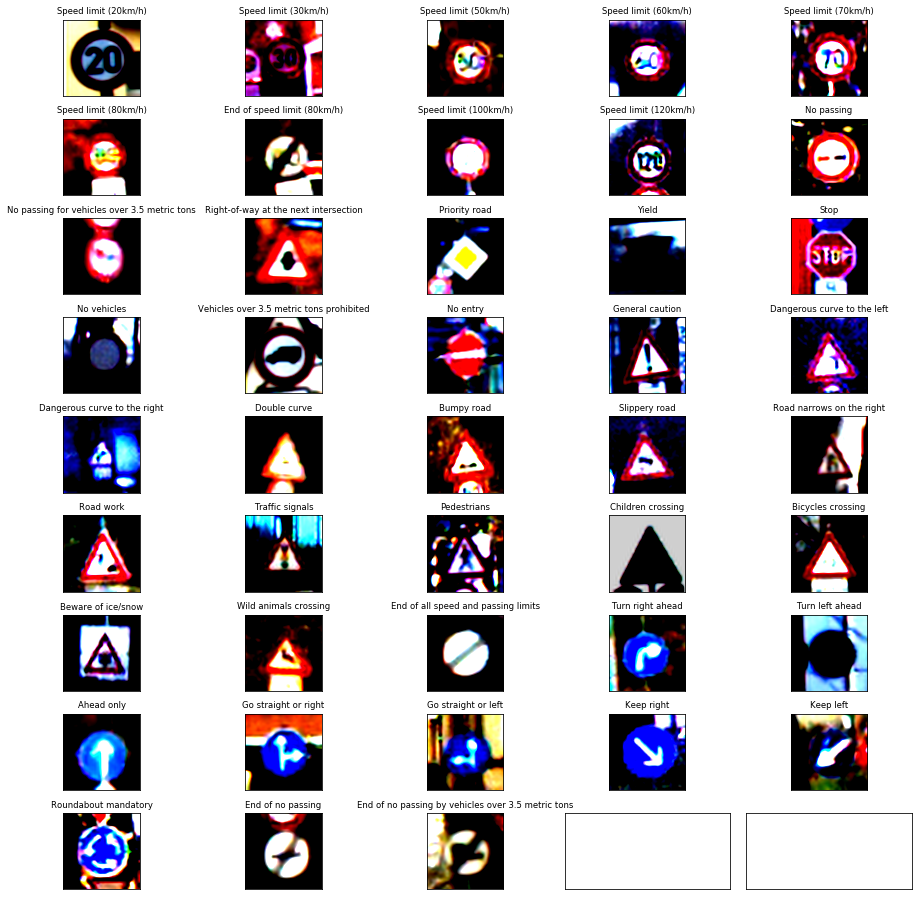

In [9]:
fig, axes = plt.subplots(rows, columns, figsize=figsize,
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.10)

for ax, i in zip(axes.flat, indices):
    ax.imshow(X_train[i], interpolation='lanczos', cmap='viridis')
    ax.set_title(sign_names[y_train[i]], fontsize=fontsize)
    
plt.show()

In [10]:
import math

def distort_input_gpu(x_in):
    
    x_t = tf.cast(x_in, dtype=tf.float32)
    x_t = tf.map_fn(lambda img: tf.random_crop(img, [32, 32, use_n_channels]), x_t, dtype=tf.float32)
    x_t = tf.map_fn(lambda img: tf.image.random_brightness(img, max_delta=63./255.), x_t, dtype=tf.float32)
    x_t = tf.map_fn(lambda img: tf.image.random_saturation(img, lower=0.5, upper=1.5), x_t, dtype=tf.float32)
    x_t = tf.map_fn(lambda img: tf.image.random_hue(img, max_delta=0.2), x_t, dtype=tf.float32)
    x_t = tf.map_fn(lambda img: tf.image.random_contrast(img, lower=0.2, upper=1.8), x_t, dtype=tf.float32)
    x_t = tf.map_fn(lambda img: tf.image.per_image_standardization(img), x_t, dtype=tf.float32)
    
    with tf.Session() as sess:
        x_out = x_t.eval()
    return x_out

In [11]:
def augment_class(x_in, y_in, classid, target):

    x_augment = np.empty([0,32, 32, 3])
    y_augment = []
    running_total = 0

    selected_class = np.where(y_in == classid)
    x_class_agument = []
    while running_total < target:

        for i in selected_class[0]:
            x_class_agument.append(x_in[i])
            y_augment.append(classid)
            running_total += 1
            if running_total >= target:
                break
                
    distorted_x = distort_input_gpu(np.array(x_class_agument))
    x_augment= np.append(x_augment, distorted_x, axis=0)
    print(classid, " ", end="")
    
    return x_augment, y_augment  

In [12]:
%%time
if save_augmented_data:
    D = Counter(y_train)
    max_count = max(D.values()) * 2
    
    for classid, count in D.items():
        target = max_count-count
        if target > 0:
            x_augment, y_augment = augment_class(X_train, y_train, classid, target)
            with open("augmented_data/" + str(classid) + "x", mode='wb') as f:
                np.save(f, x_augment)
            with open("augmented_data/" + str(classid) + "y", mode='wb') as f:
                np.save(f, np.array(y_augment))


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.54 µs


##### Augmented Data Preview

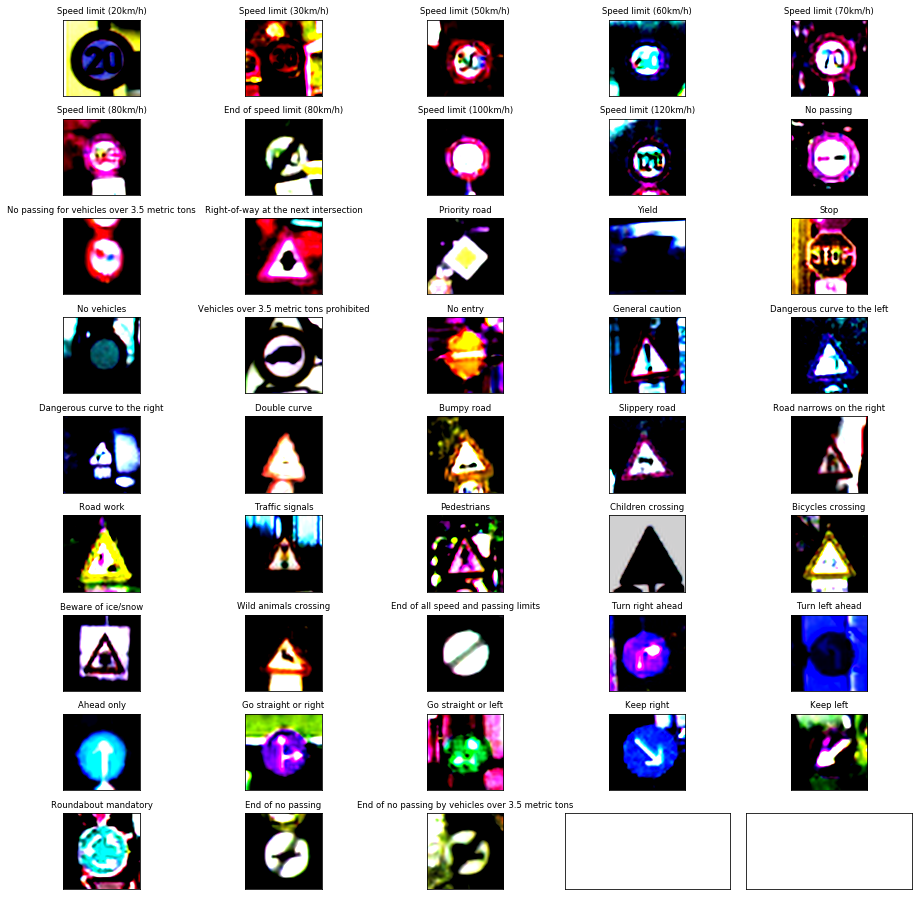

CPU times: user 26.4 s, sys: 28.8 s, total: 55.2 s
Wall time: 59.9 s


In [13]:
%%time
import os.path
fig, axes = plt.subplots(rows, columns, figsize=figsize,
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.10)

for classid in range(n_classes):
    file_path = "augmented_data/" + str(classid) + "x"
    if os.path.exists(file_path):
        with open( file_path, mode='rb') as f:
            x_augment = np.load(f)
        with open("augmented_data/" + str(classid) + "y", mode='rb') as f:
            y_augment = np.load(f)
        X_train = np.append(X_train, x_augment, axis=0)
        y_train = np.append(y_train, y_augment, axis=0)
        
        axes.flat[classid].imshow(x_augment[0], interpolation='lanczos', cmap='viridis')
        axes.flat[classid].set_title(sign_names[classid], fontsize=fontsize)
plt.show()

In [14]:
X_train, y_train = shuffle(X_train, y_train)

##### New Training Data Summary after Augmentation

In [15]:
n_train = len(X_train)
image_shape = X_train[0].shape
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 172860
Image data shape = (32, 32, 3)
Number of classes = 43


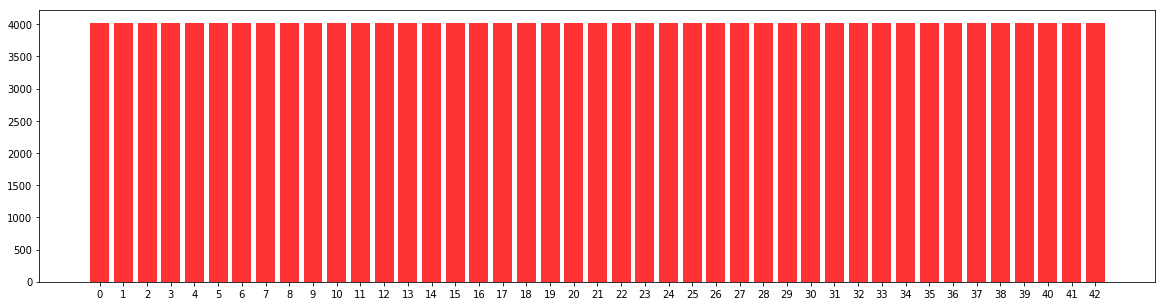

In [16]:
fig, ax = plt.subplots(figsize=(20,5))

D = Counter(y_train)
plt.xticks(range(len(D)), D.keys())
plot = plt.bar(range(len(D)), D.values(), color="red", alpha=0.8, label='New Training')

In [17]:
import tensorflow as tf

EPOCHS = 90
BATCH_SIZE = 1024

### Model Architecture

In [18]:
  def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
      mean = tf.reduce_mean(var)
      tf.summary.scalar('mean', mean)
      with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
      tf.summary.scalar('stddev', stddev)
      tf.summary.scalar('max', tf.reduce_max(var))
      tf.summary.scalar('min', tf.reduce_min(var))
      tf.summary.histogram('histogram', var)

In [19]:
from tensorflow.contrib.layers import flatten

def LeNet_Fast(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    with tf.name_scope('dropout_in'):
        x_drop = tf.nn.dropout(x, keep_prob_in)
    
    with tf.name_scope("Convolutional_1"):
        with tf.name_scope('weights'):
            # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
            conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, use_n_channels, 6), mean = mu, stddev = sigma),
                                  name="conv1_weight")
            variable_summaries(conv1_W)
        with tf.name_scope('biases'):
            conv1_b = tf.Variable(tf.zeros(6), name="conv1_bias")
            variable_summaries(conv1_b)
        conv1   = tf.nn.conv2d(x_drop, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

        # SOLUTION: Activation.
        conv1 = tf.nn.relu(conv1)

        # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='conv1')

    with tf.name_scope('dropout_conv'):    
        conv1_drop = tf.nn.dropout(conv1, keep_prob_conv)
    
    with tf.name_scope("Convolutional_2"):
        with tf.name_scope('weights'):
            # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
            conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma),
                             name="conv2_weight")
            variable_summaries(conv2_W)
        with tf.name_scope('biases'):
            conv2_b = tf.Variable(tf.zeros(16), name="conv2_bias")
            variable_summaries(conv2_b)
        conv2   = tf.nn.conv2d(conv1_drop, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
        # SOLUTION: Activation.
        conv2 = tf.nn.relu(conv2)

        # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='conv2')

    with tf.name_scope("flatten"):        
        # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
        fc0   = flatten(conv2)
    
    with tf.name_scope("FullyConnected_1"):
        # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
        fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
        fc1_b = tf.Variable(tf.zeros(120))
        fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
        # SOLUTION: Activation.
        fc1    = tf.nn.relu(fc1)

    with tf.name_scope("FullyConnected_2"):
        # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
        fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
        fc2_b  = tf.Variable(tf.zeros(84))
        fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
        # SOLUTION: Activation.
        fc2    = tf.nn.relu(fc2)

    with tf.name_scope('dropout_fc'):    
        fc2_drop = tf.nn.dropout(fc2, keep_prob_fc)

    with tf.name_scope("FullyConnected_3"):
        # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
        fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
        fc3_b  = tf.Variable(tf.zeros(43))
        logits = tf.matmul(fc2_drop, fc3_W) + fc3_b
    
    return logits

In [20]:
from tensorflow.contrib.layers import flatten

def LeNet_Deep(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    with tf.name_scope('dropout_in'):
        x_drop = tf.nn.dropout(x, keep_prob_in)
    
    with tf.name_scope("Convolutional_1"):
        with tf.name_scope('weights'):
            # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x32.
            conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, use_n_channels, 32), 
                                                      mean = mu, stddev = sigma), name="conv1_weight")
            variable_summaries(conv1_W)
        with tf.name_scope('biases'):
            conv1_b = tf.Variable(tf.zeros(32), name="conv1_bias")
            variable_summaries(conv1_b)
        conv1   = tf.nn.conv2d(x_drop, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

        # SOLUTION: Activation.
        conv1 = tf.nn.relu(conv1)

        # SOLUTION: Pooling. Input = 28x28x32. Output = 14x14x32.
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='conv1')

    with tf.name_scope('dropout_conv'):    
        conv1_drop = tf.nn.dropout(conv1, keep_prob_conv)
    
    with tf.name_scope("Convolutional_2"):
        with tf.name_scope('weights'):
            # SOLUTION: Layer 2: Convolutional. Output = 10x10x64.
            conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma),
                             name="conv2_weight")
            variable_summaries(conv2_W)
        with tf.name_scope('biases'):
            conv2_b = tf.Variable(tf.zeros(64), name="conv2_bias")
            variable_summaries(conv2_b)
        conv2   = tf.nn.conv2d(conv1_drop, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
        # SOLUTION: Activation.
        conv2 = tf.nn.relu(conv2)

        # SOLUTION: Pooling. Input = 10x10x64. Output = 5x5x64.
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='conv2')

    with tf.name_scope("flatten"):        
        # SOLUTION: Flatten. Input = 5x5x64. Output = 1600.
        fc0   = flatten(conv2)
    
    with tf.name_scope("FullyConnected_1"):
        # SOLUTION: Layer 3: Fully Connected. Input = 1600. Output = 120.
        fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 120), mean = mu, stddev = sigma))
        fc1_b = tf.Variable(tf.zeros(120))
        fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
        # SOLUTION: Activation.
        fc1    = tf.nn.relu(fc1)

    with tf.name_scope("FullyConnected_2"):
        # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
        fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
        fc2_b  = tf.Variable(tf.zeros(84))
        fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
        # SOLUTION: Activation.
        fc2    = tf.nn.relu(fc2)

    with tf.name_scope('dropout_fc'):    
        fc2_drop = tf.nn.dropout(fc2, keep_prob_fc)

    with tf.name_scope("FullyConnected_3"):
        # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
        fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
        fc3_b  = tf.Variable(tf.zeros(43))
        logits = tf.matmul(fc2_drop, fc3_W) + fc3_b
    
    return logits

In [21]:
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, (None, 32, 32, use_n_channels), name="x")
    y = tf.placeholder(tf.int32, (None), name="labels")
with tf.name_scope('dropout_in'):
    keep_prob_in = tf.placeholder(tf.float32, name="keep_prob_in")
with tf.name_scope('dropout_conv'):
    keep_prob_conv = tf.placeholder(tf.float32, name="keep_prob_conv")    
with tf.name_scope('dropout_fc'):    
    keep_prob_fc = tf.placeholder(tf.float32, name="keep_prob_fc")
one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [22]:
rate = 0.001

logits = LeNet_Deep(x)
with tf.name_scope('cross_entropy'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
with tf.name_scope("total"):
    loss_operation = tf.reduce_mean(cross_entropy)
tf.summary.scalar('mean', loss_operation)
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [23]:
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy_operation)
saver = tf.train.Saver()

# returns accuracy
def evaluate(X_data, y_data, index=-1):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        summary, accuracy = sess.run([merged, accuracy_operation], feed_dict={x: batch_x, y: batch_y, 
                                                            keep_prob_fc: 1., keep_prob_in: 1., 
                                                            keep_prob_conv: 1.})
        total_accuracy += (accuracy * len(batch_x))
        if index >= 0:
            train_writer.add_summary(summary, index)
        else:
            test_writer.add_summary(summary, index)
    return total_accuracy / num_examples

#returns flatten array of predictions
def get_predictions(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    predictions = []
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: batch_x, y: batch_y, keep_prob_fc: 1., 
                                                             keep_prob_in: 1., keep_prob_conv: 1.})
        test_preds = [np.argmax(row) for row in softmax]
        predictions.append(test_preds)              
    return sum(predictions, [])

In [24]:
with tf.Session() as sess:
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter("log" + '/train', sess.graph)
    test_writer = tf.summary.FileWriter("log" + '/test')

In [25]:
%%time
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = rate).minimize(
        cross_entropy)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]            
            summary, _ = sess.run([merged, train_step], feed_dict={x: batch_x, y: batch_y, keep_prob_fc: 0.5, 
                                                      keep_prob_in: 0.99, keep_prob_conv: 0.9})
            train_writer.add_summary(summary, i)
            
        validation_accuracy = evaluate(X_valid, y_valid, i)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './lenet')
    traning_accuracy = evaluate(X_train, y_train)
    print("Training Accuracy = {:.3f}".format(traning_accuracy))    

Training...

EPOCH 1 ...
Validation Accuracy = 0.838

EPOCH 2 ...
Validation Accuracy = 0.922

EPOCH 3 ...
Validation Accuracy = 0.941

EPOCH 4 ...
Validation Accuracy = 0.955

EPOCH 5 ...
Validation Accuracy = 0.959

EPOCH 6 ...
Validation Accuracy = 0.961

EPOCH 7 ...
Validation Accuracy = 0.963

EPOCH 8 ...
Validation Accuracy = 0.962

EPOCH 9 ...
Validation Accuracy = 0.963

EPOCH 10 ...
Validation Accuracy = 0.962

EPOCH 11 ...
Validation Accuracy = 0.964

EPOCH 12 ...
Validation Accuracy = 0.967

EPOCH 13 ...
Validation Accuracy = 0.970

EPOCH 14 ...
Validation Accuracy = 0.964

EPOCH 15 ...
Validation Accuracy = 0.966

EPOCH 16 ...
Validation Accuracy = 0.965

EPOCH 17 ...
Validation Accuracy = 0.963

EPOCH 18 ...
Validation Accuracy = 0.961

EPOCH 19 ...
Validation Accuracy = 0.964

EPOCH 20 ...
Validation Accuracy = 0.968

EPOCH 21 ...
Validation Accuracy = 0.962

EPOCH 22 ...
Validation Accuracy = 0.966

EPOCH 23 ...
Validation Accuracy = 0.965

EPOCH 24 ...
Validation Accura

In [26]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    with tf.name_scope('test'):
        traning_accuracy = evaluate(X_train, y_train)
        print("Training Accuracy = {:.3f}".format(traning_accuracy))

Training Accuracy = 1.000


# Test Accuracy

In [27]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    predictions = get_predictions(X_test, y_test)

Test Accuracy = 0.963


In [28]:
train_writer.close()
test_writer.close()

###  Detailed Analysis of Model Performance 

#### Precision

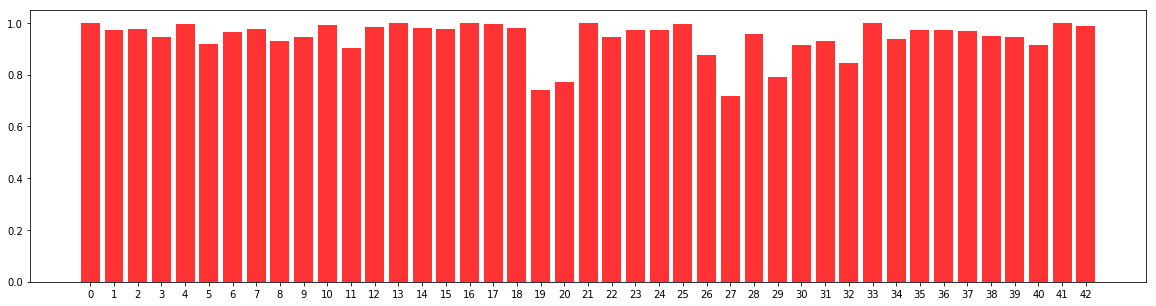

In [29]:
from sklearn.metrics import precision_recall_fscore_support
precision,recall, fbeta_score, _ = precision_recall_fscore_support(y_test, predictions, average=None)

fig, ax = plt.subplots(figsize=(20,5))
plt.xticks(range(n_classes), range(n_classes))
plot = plt.bar(range(n_classes), precision, color="red", alpha=0.8, label='precision')

#### Recall

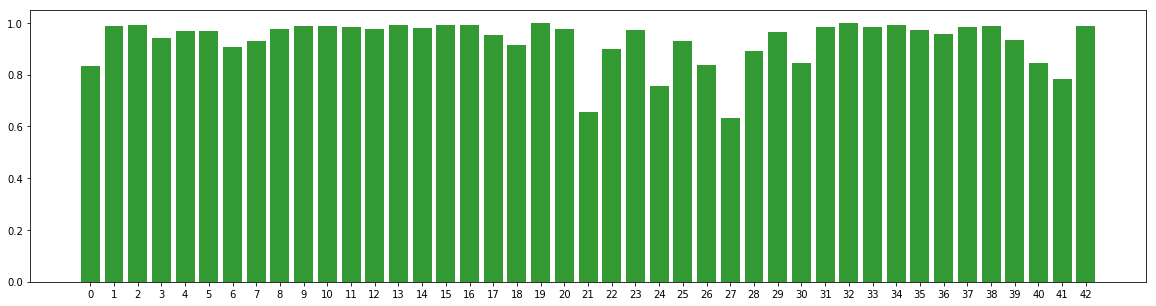

In [30]:
fig, ax = plt.subplots(figsize=(20,5))
plt.xticks(range(n_classes), range(n_classes))
plot = plt.bar(range(n_classes), recall, color="green", alpha=0.8, label='Recall')

#### Fβ score

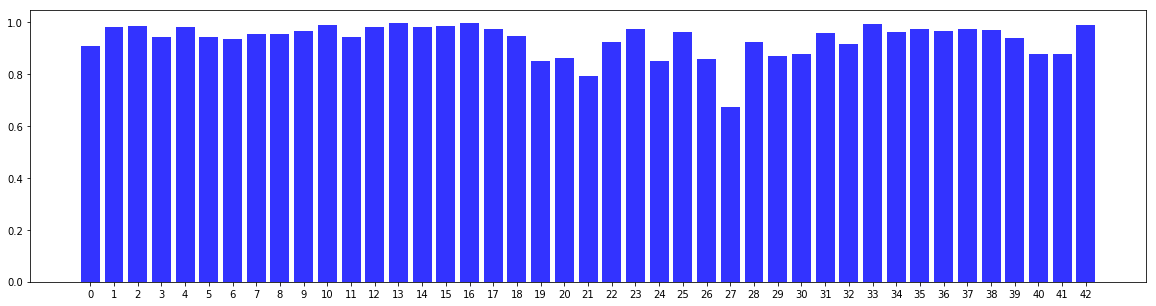

In [31]:
fig, ax = plt.subplots(figsize=(20,5))
plt.xticks(range(n_classes), range(n_classes))
plot = plt.bar(range(n_classes), fbeta_score, color="blue", alpha=0.8, label='Recall')

#### Confusion Matrix

In [32]:
# Adopted from: http://scikit-learn.org/stable/_downloads/plot_confusion_matrix.py
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(orientation='horizontal')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


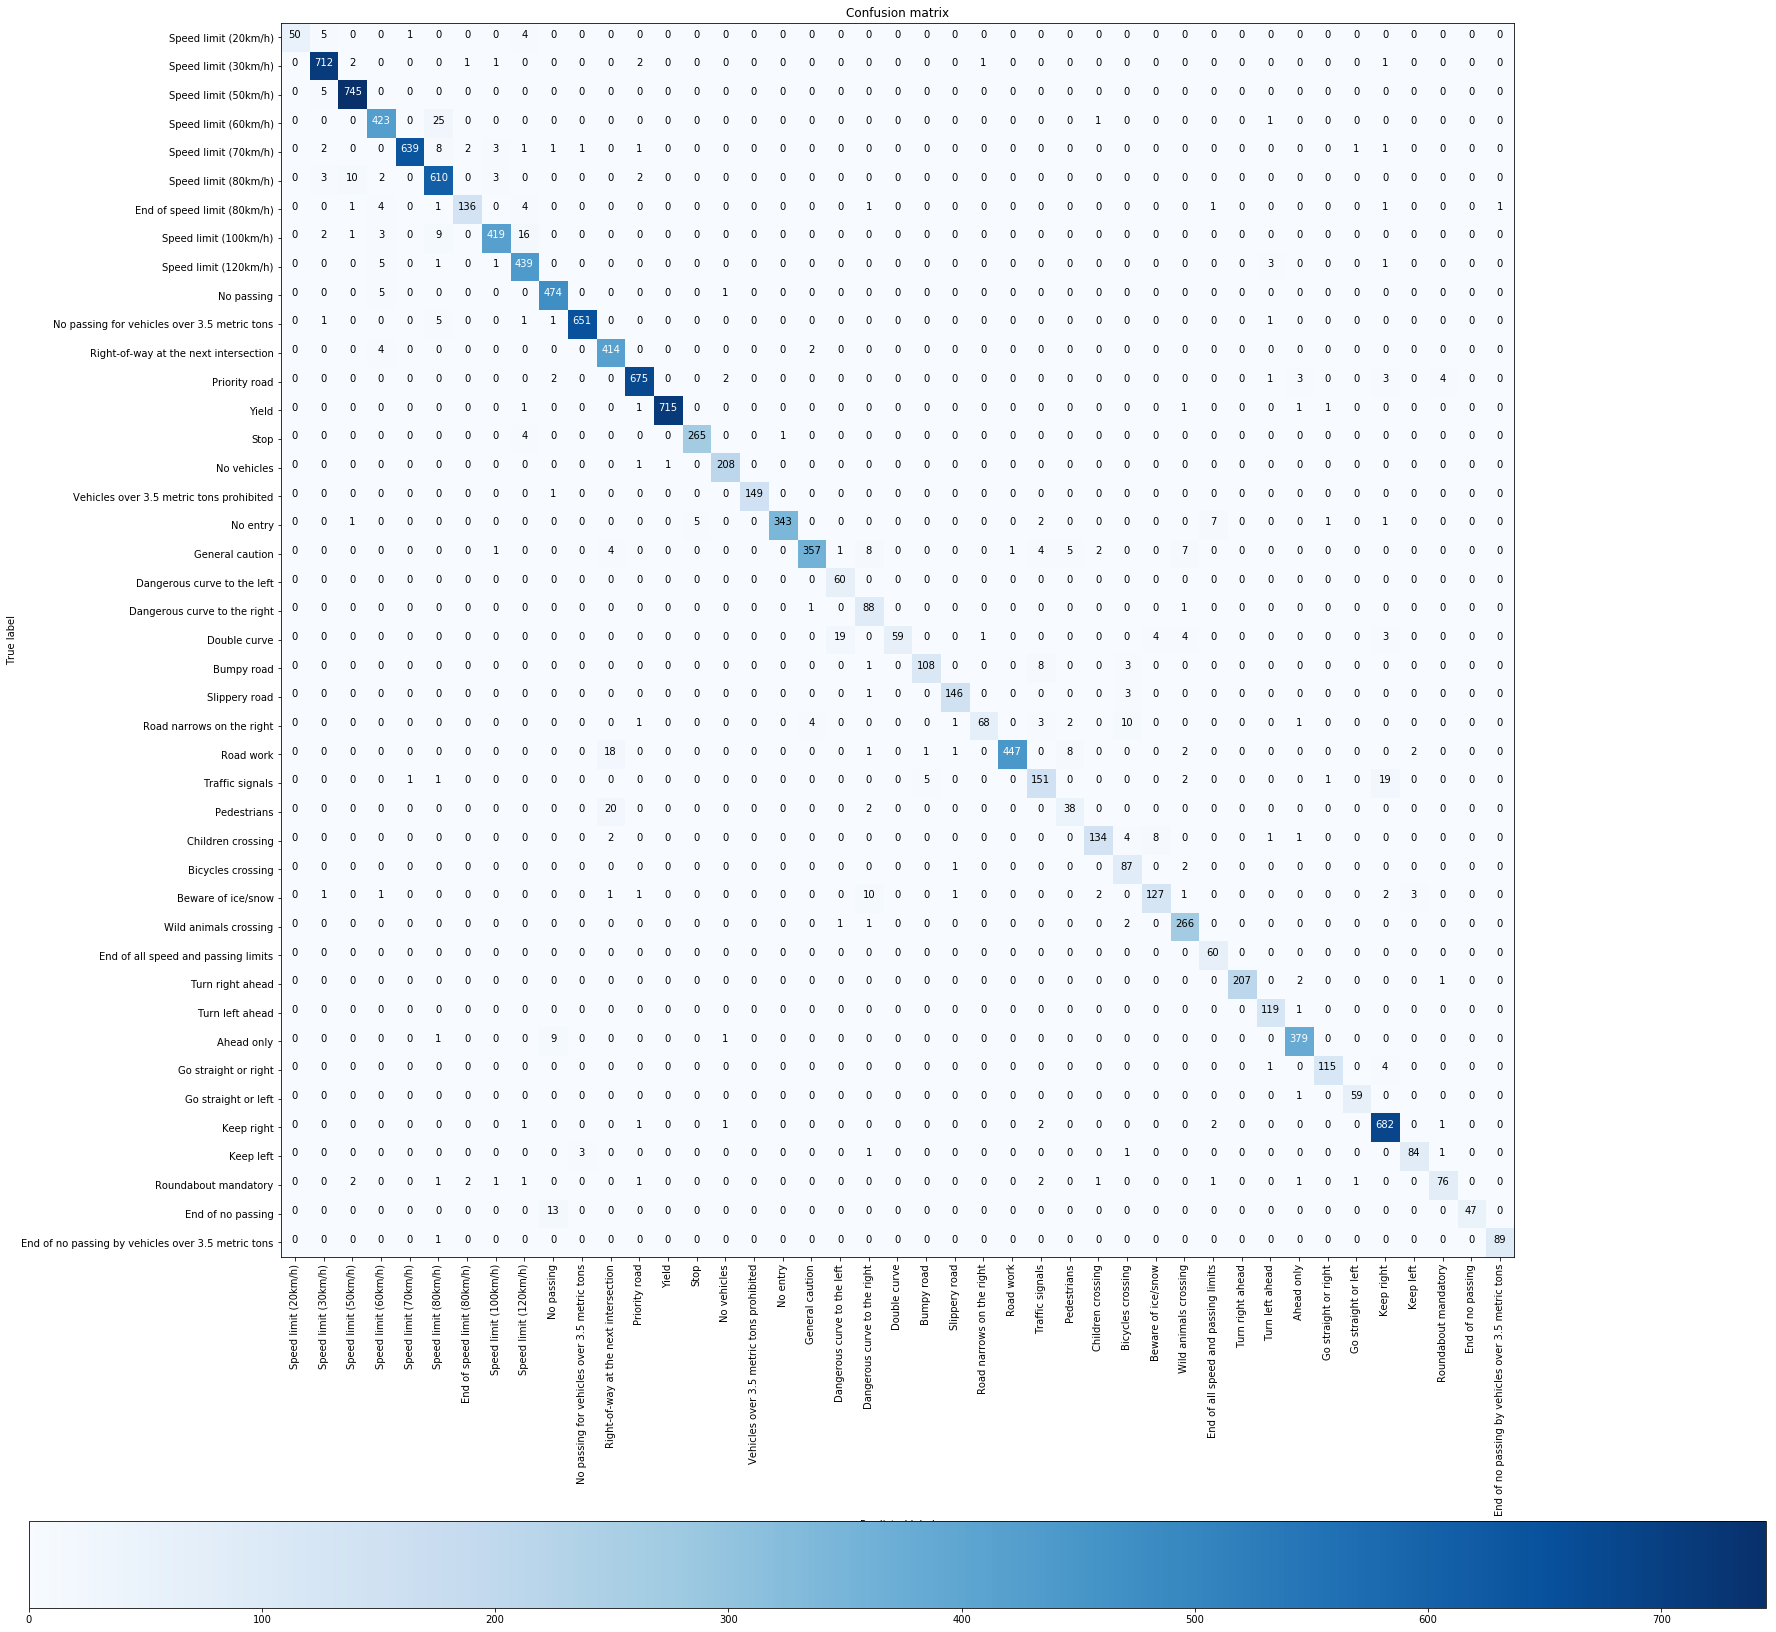

In [33]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(25,25))
plot_confusion_matrix(c_matrix, classes=sign_names.values())

Normalized confusion matrix


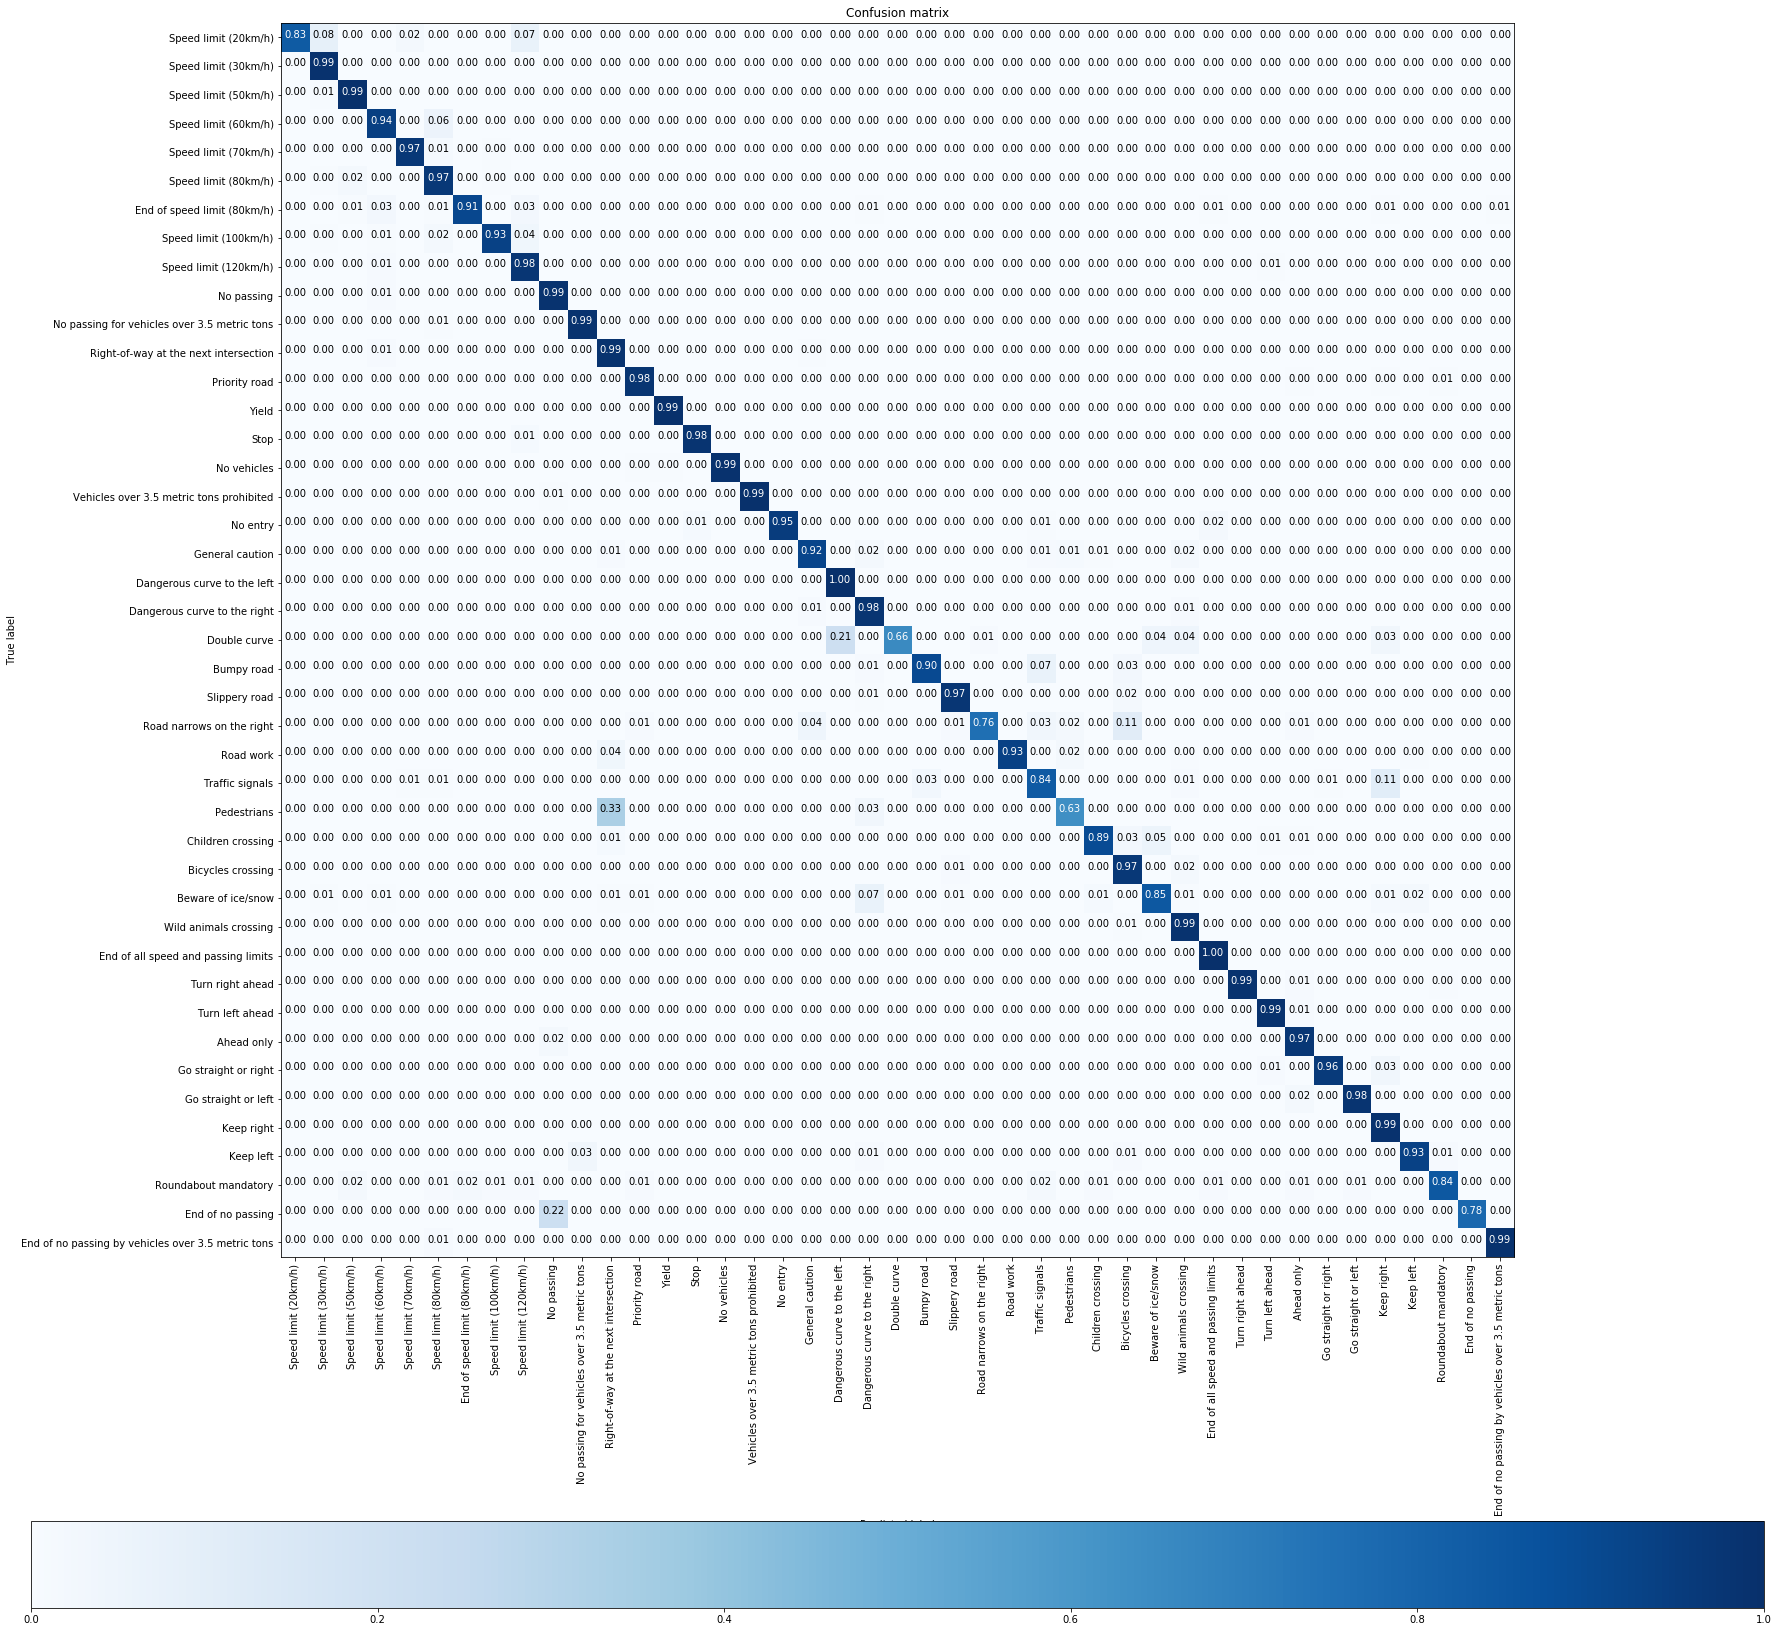

In [34]:
plt.figure(figsize=(25,25))
plot_confusion_matrix(c_matrix, classes=sign_names.values(), normalize=True)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load and Output the Images

In [35]:
from PIL import Image
from scipy import misc
import numpy                                                                     
import glob

imageFolderPath = 'my_own_images/'
imagePath = glob.glob(imageFolderPath + '/*.png') 

X_myown = numpy.array( [numpy.array(misc.imread(img, mode='RGB')) for img in imagePath] )
Y_myown = numpy.array( [int(path.split("/")[1].split(".")[0]) for path in imagePath])


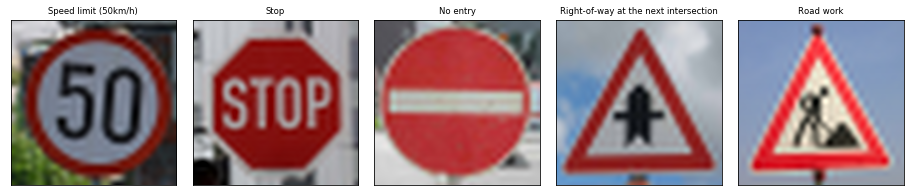

In [36]:
count = len(X_myown)
columns = count
rows = 1

fig, axes = plt.subplots(rows, columns, figsize=figsize,
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.10)

indices = range(count)

for ax, i in zip(axes.flat, indices):
    ax.imshow(X_myown[i], interpolation='lanczos')
    ax.set_title(sign_names[Y_myown[i]], fontsize=fontsize)
    
plt.show()

#### Pre-Processing

In [37]:
%%time
X_myown = preprocess_gpu(X_myown)

CPU times: user 212 ms, sys: 92 ms, total: 304 ms
Wall time: 295 ms


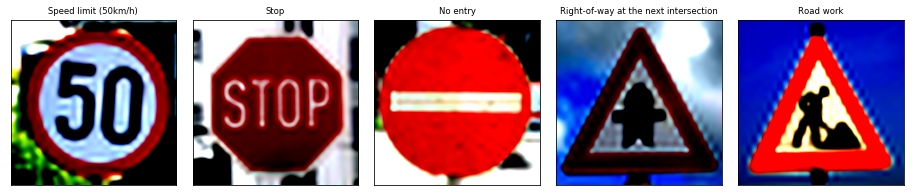

In [38]:
fig, axes = plt.subplots(rows, columns, figsize=figsize,
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.10)

indices = range(count)

for ax, i in zip(axes.flat, indices):
    ax.imshow(X_myown[i], interpolation='lanczos')
    ax.set_title(sign_names[Y_myown[i]], fontsize=fontsize)
    
plt.show()

### Predict the Sign Type for Each Image

In [39]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_myown, Y_myown)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    predictions = get_predictions(X_myown, Y_myown)

Test Accuracy = 0.800


### Analyze Performance

In [40]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

In [41]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sf = sess.run(tf.nn.softmax(logits), feed_dict={x: X_myown, y: Y_myown, keep_prob_fc: 1., 
                                                             keep_prob_in: 1., keep_prob_conv: 1.})
    topk = sess.run(tf.nn.top_k(tf.constant(sf), k=3))

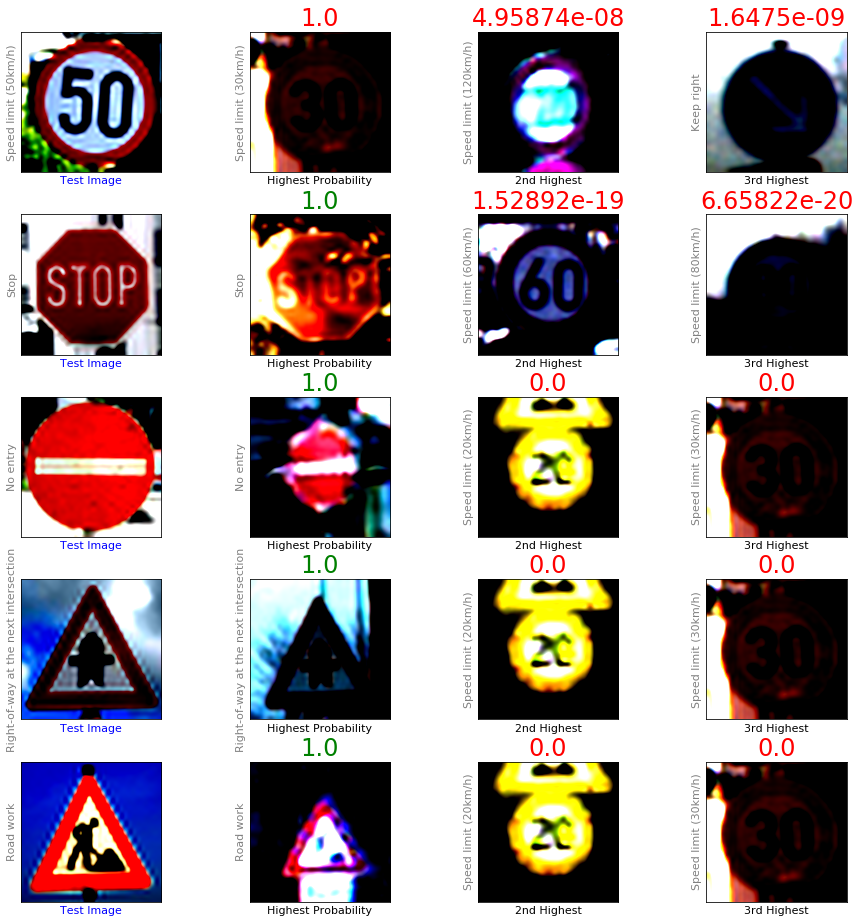

In [42]:
fig, axes = plt.subplots(5, 4, figsize=figsize,
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.10)
x_label = ["Highest Probability", "2nd Highest", "3rd Highest"]

for index in indices:
    axes[index][0].imshow(X_myown[index], interpolation='lanczos')
    axes[index][0].set_ylabel(sign_names[Y_myown[index]], fontsize=11, color="grey")
    axes[index][0].set_xlabel("Test Image", fontsize=11, color="blue")
    
    for num, name in enumerate(topk.indices[index]):
        ax = axes[index][num+1]
        ax.imshow(X_train[numpy.where(y_train==name)[0][0]], interpolation='lanczos')
        score = topk.values[index][num]                    
        color = "green" if name == Y_myown[index] else "red"    # green color for correct prediction
        ax.set_title(str(score), fontsize=24, color=color)
        ax.set_ylabel(sign_names[name], fontsize=11, color="grey")
        ax.set_xlabel(x_label[num], fontsize=11)
    
plt.show()

---

## Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.


In [43]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input,  keep_prob_fc: 1., 
                                                             keep_prob_in: 1., keep_prob_conv: 1.})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,20))
    for featuremap in range(featuremaps):
        plt.subplot(8,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

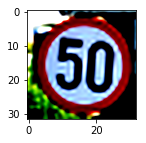

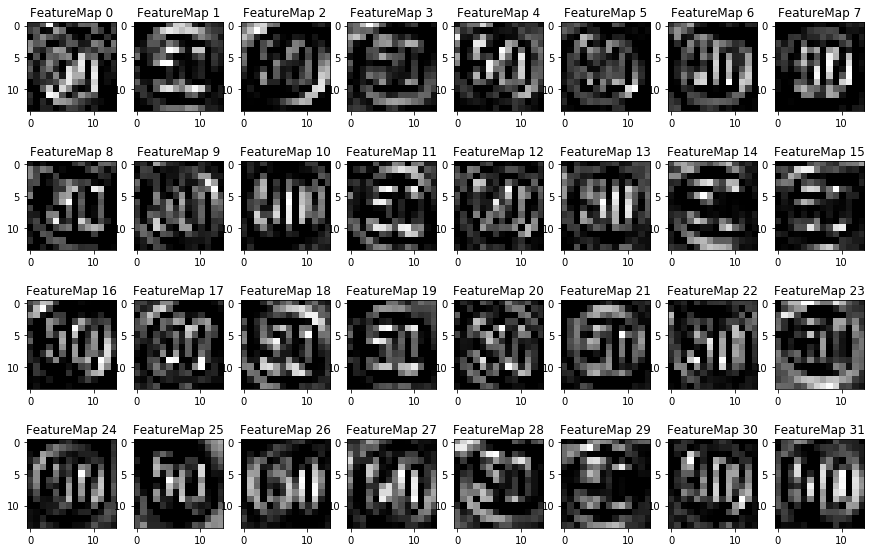

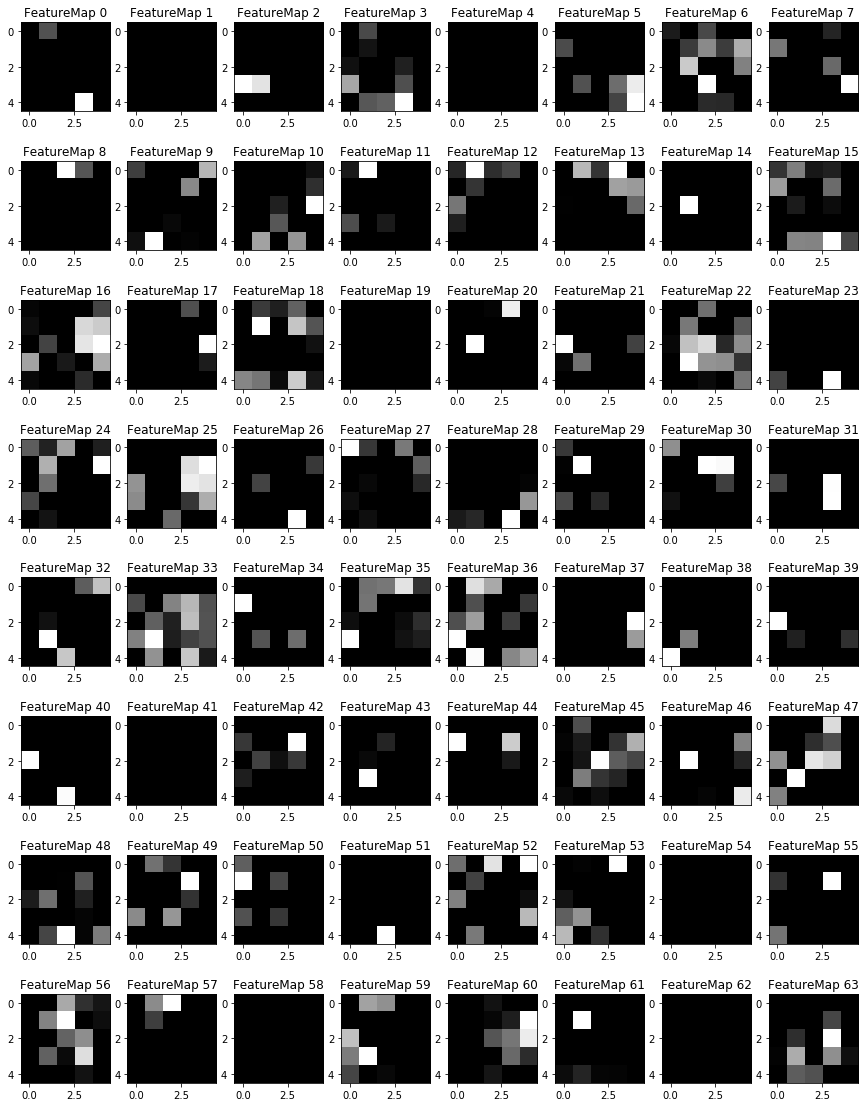

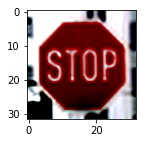

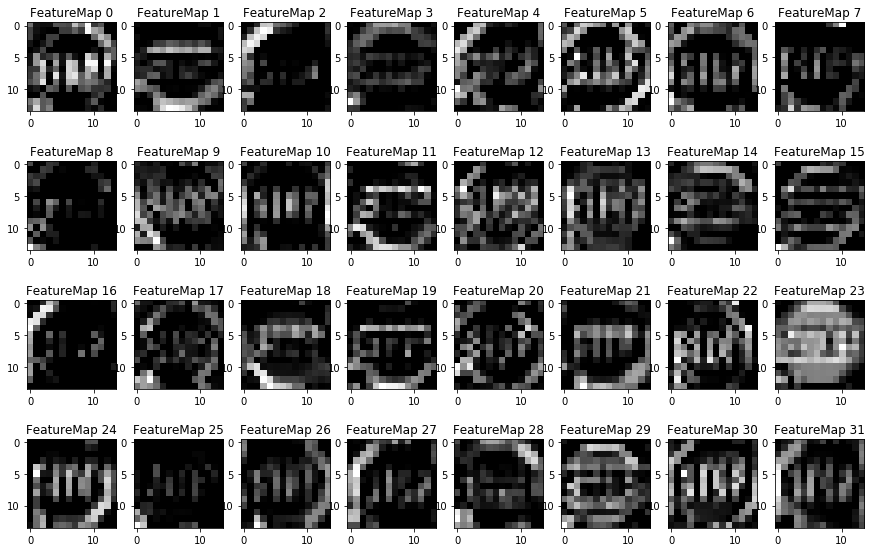

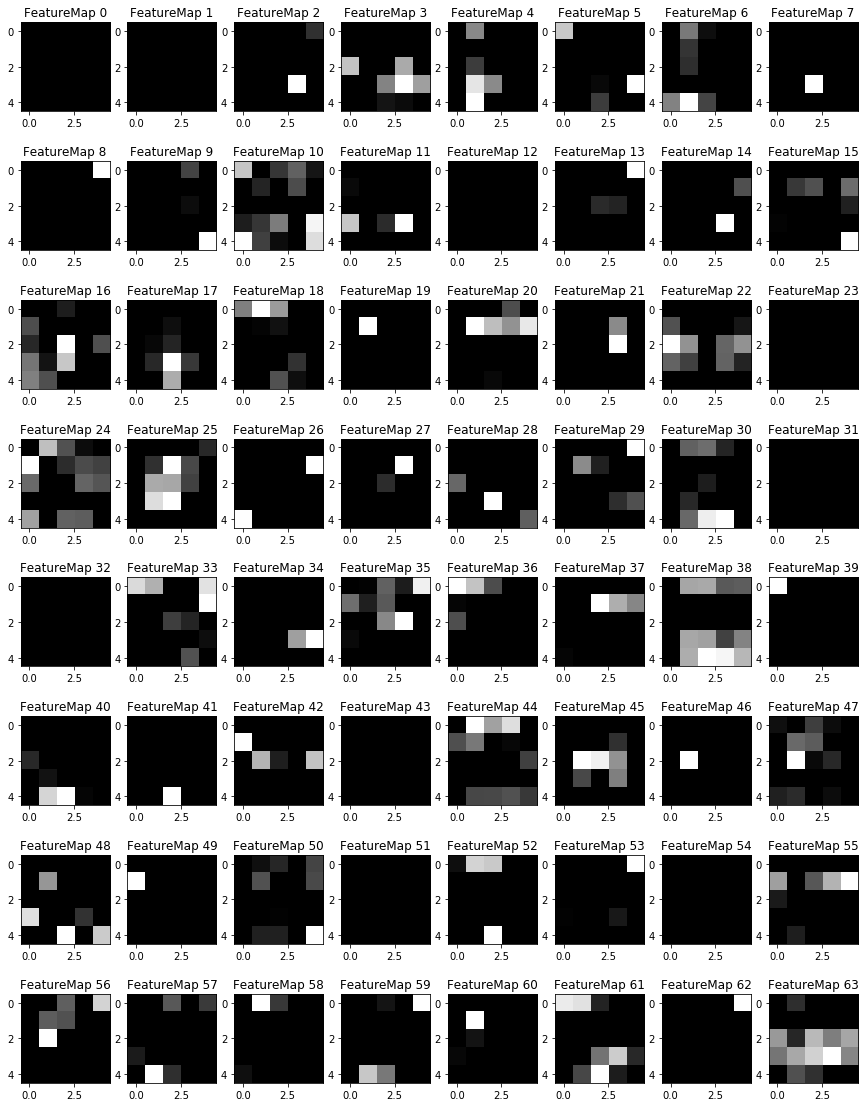

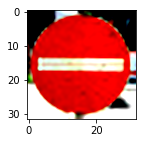

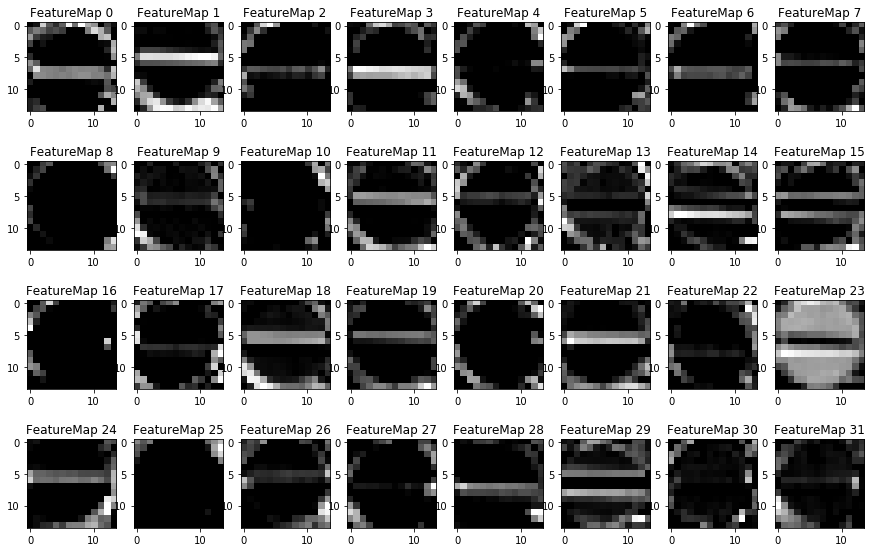

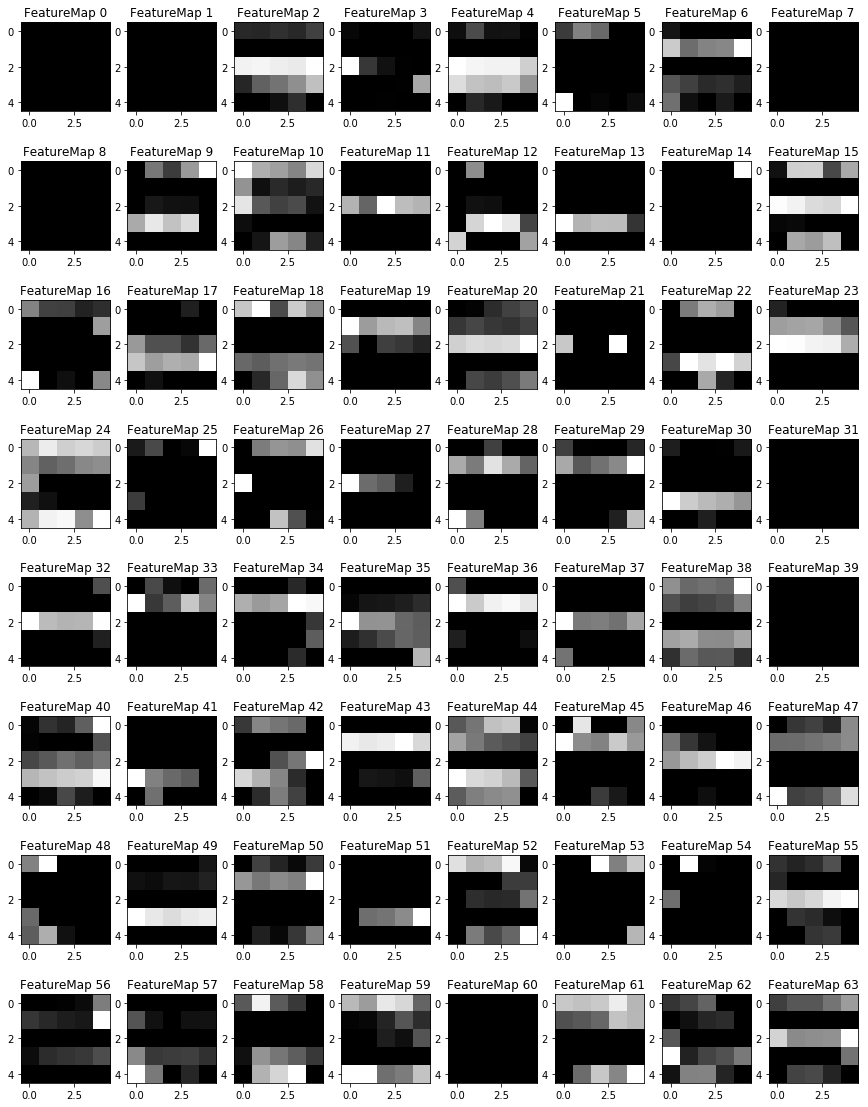

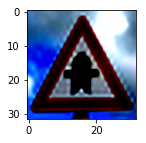

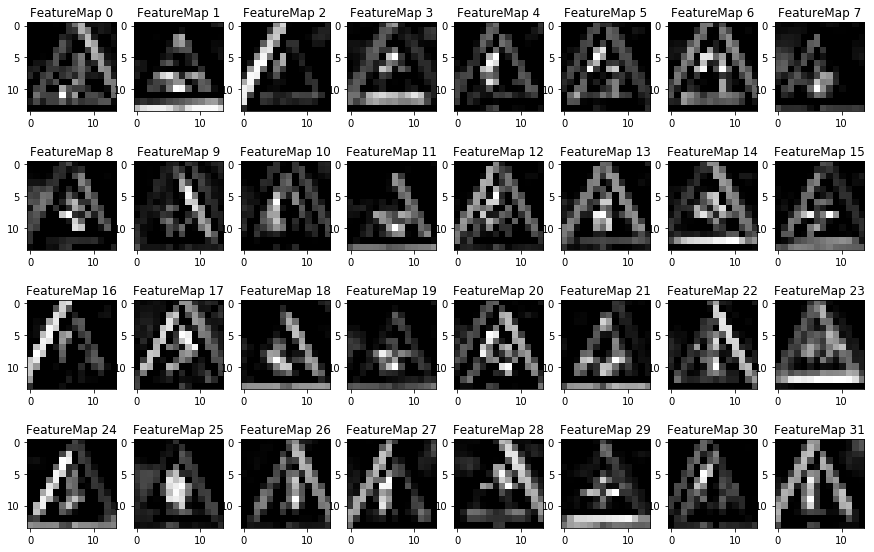

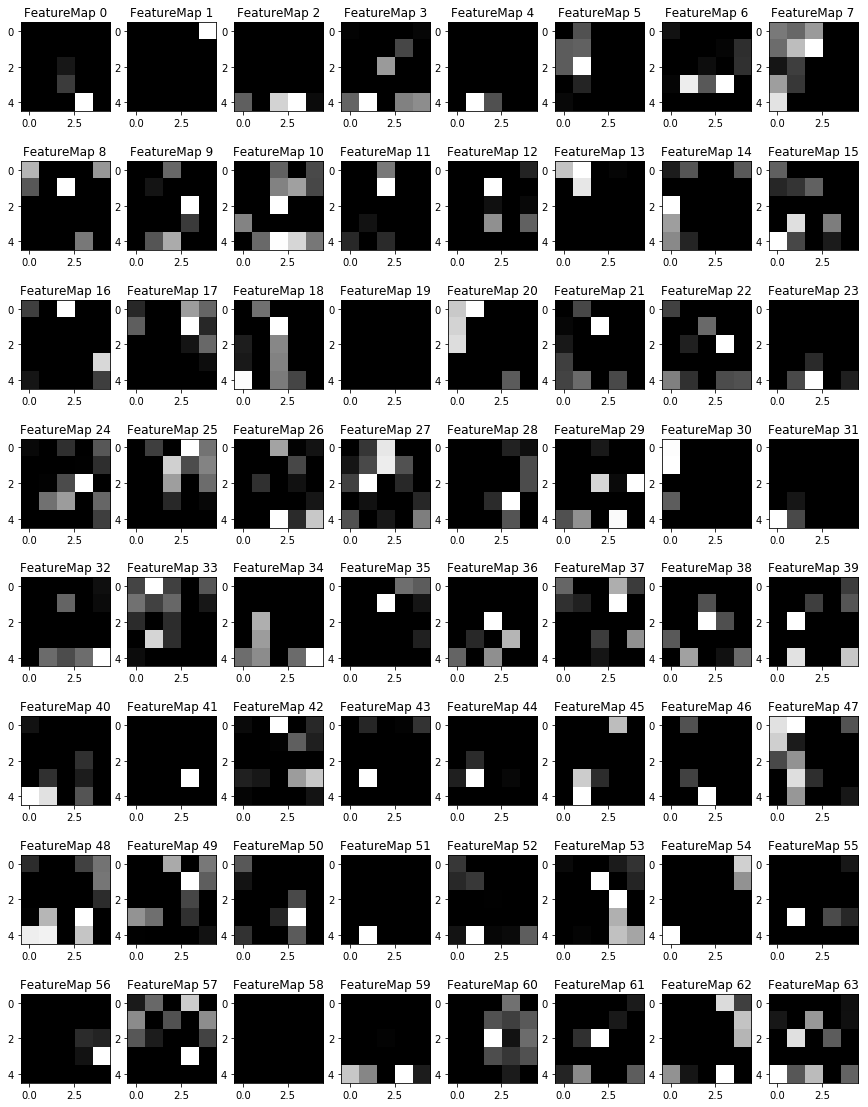

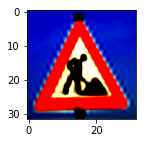

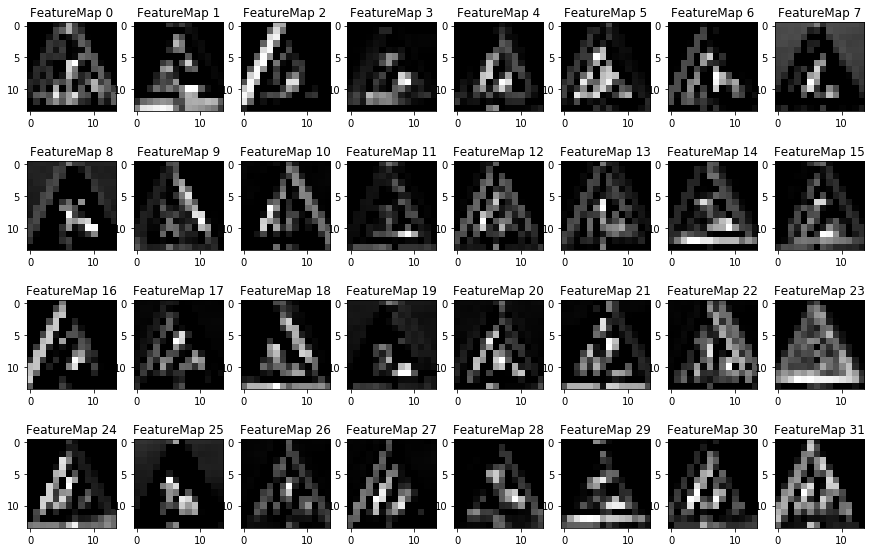

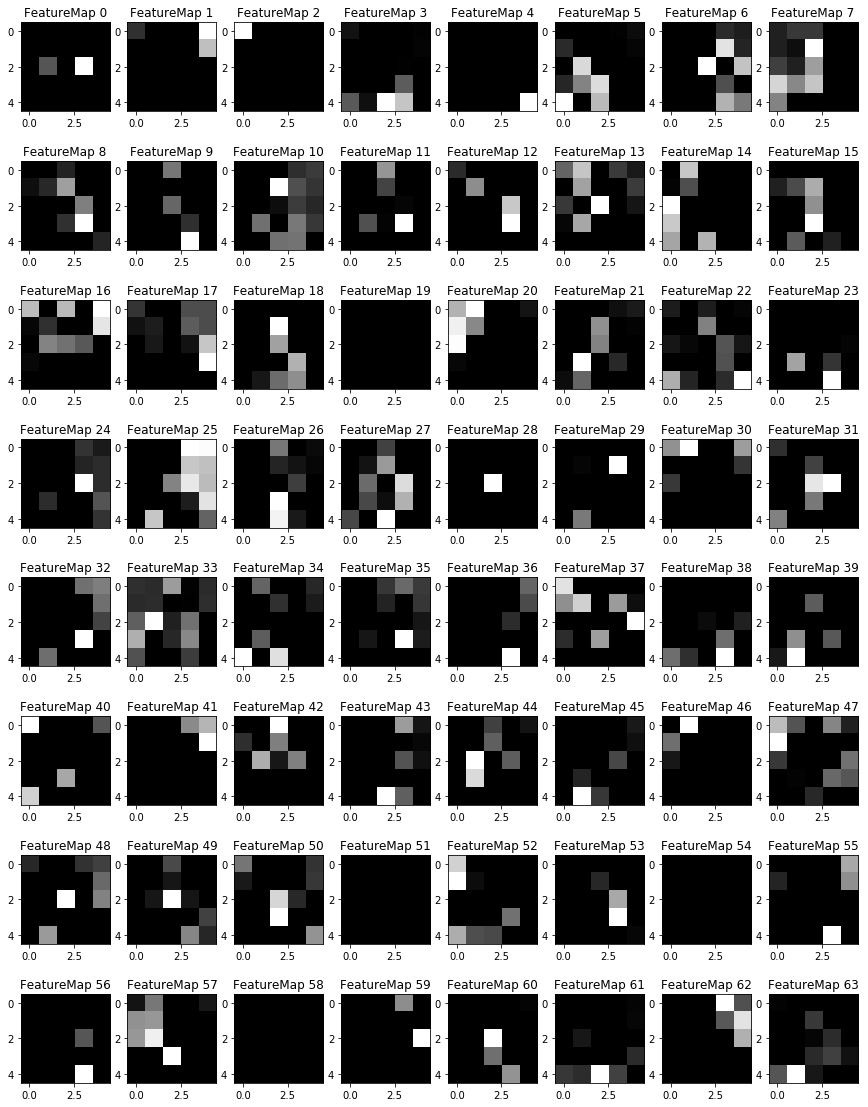

In [44]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    for i in indices:
        plt.figure(0, figsize=(2,2))
        plt.imshow(X_myown[i], interpolation='lanczos')
        test_accuracy = evaluate(X_myown[i:i+1], Y_myown[i:i+1])
        tf_activation = sess.graph.get_tensor_by_name('Convolutional_1/conv1:0')
        outputFeatureMap(X_myown[i:i+1], tf_activation, plt_num=1)
        tf_activation2 = sess.graph.get_tensor_by_name('Convolutional_2/conv2:0')
        outputFeatureMap(X_myown[i:i+1], tf_activation2, plt_num=2)
        plt.show()